In [1]:
import numpy as np
import h5py
import plumed
from scipy.spatial import distance
from scipy.linalg import eigh
import tables as tb
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from numba import jit
import time

# Functions

In [2]:
def dmap(data,sigma,weights=None,n=2):
  # data[i,j]: j-th component of i-th datapoint
  # sigma: cutoff
  # weights: weight of each point
  # n: number of coordinates to extract

  # returns pair with eigenvalues and projections
  
  from scipy.spatial import distance
  from scipy.linalg import eigh
    
  dist=distance.squareform(distance.pdist(data))
  print(dist)
  K=np.exp(-0.5*dist**2/sigma**2)

  if weights is None:
    weights=np.ones(data.shape[0])
  for i in range(1000):
    D=np.dot(K,weights)
    if np.sum((D-1)**2)<1e-14:
      break
    D=1/D**0.5
    K=np.outer(D,D)*K
  if i == 1000:
    print("warning, not converged")
  TT=np.outer(np.sqrt(weights),np.sqrt(weights))*K
  normweights=weights/np.sum(weights)
  ew,ev=eigh(TT) # not working for some reason: ,subset_by_index=[len(data)-n,len(data)-1])
    
  # check first eigenvalue
  # assert ((ew[-1]-1)**2)<1e-14

  # check first eigenvector
  # assert np.std(ev[:,-1]/np.sqrt(weights))<1e-7
  
  return ew[-2:-2-n:-1],ev[:,-2:-2-n:-1].T/np.sqrt(normweights)[np.newaxis]

def dmap_pytables(data,dist,sigma,weights=None,n=2):
    
  K=np.exp(-0.5*dist**2/sigma**2)

  if weights is None:
    weights=np.ones(data.shape[0])
  for i in range(1000):
    D=np.dot(K,weights)
    if np.sum((D-1)**2)<1e-14:
      break
    D=1/D**0.5
    K=np.outer(D,D)*K
  if i == 1000:
    print("warning, not converged")
  TT=np.outer(np.sqrt(weights),np.sqrt(weights))*K
  normweights=weights/np.sum(weights)
  ew,ev=eigh(TT) # not working for some reason: ,subset_by_index=[len(data)-n,len(data)-1])
    
  # check first eigenvalue
  # assert ((ew[-1]-1)**2)<1e-14

  # check first eigenvector
  # assert np.std(ev[:,-1]/np.sqrt(weights))<1e-7
  
  return ew[-2:-2-n:-1],ev[:,-2:-2-n:-1].T/np.sqrt(normweights)[np.newaxis]



In [3]:
def conformer(colvar):
    df = plumed.read_as_pandas("{}".format(colvar))
    cf = df.drop(columns=['time'])
    cfheader = cf.columns

    # Convert COLVAR Angle values to binary format 5,6,7!
    cf['phi1_2'] = np.where((-np.pi <= cf['phi1_2']) & (cf['phi1_2'] < 0) , 5, cf['phi1_2'])
    cf['phi1_2'] = np.where((0 <= cf['phi1_2']) & (cf['phi1_2'] < 2.5) , 6, cf['phi1_2'])
    cf['phi1_2'] = np.where((2.5 <= cf['phi1_2']) & (cf['phi1_2'] <= np.pi) , 5, cf['phi1_2'])

    cf['psi1_2'] = np.where((-np.pi <= cf['psi1_2']) & (cf['psi1_2'] < -2.5) , 5, cf['psi1_2'])
    cf['psi1_2'] = np.where((-2.5 <= cf['psi1_2']) & (cf['psi1_2'] < 0.2) , 6, cf['psi1_2'])
    cf['psi1_2'] = np.where((0.2 <= cf['psi1_2']) & (cf['psi1_2'] <= np.pi) , 5, cf['psi1_2'])

    cf['phi2_3'] = np.where((-np.pi <= cf['phi2_3']) & (cf['phi2_3'] < 0.1) , 5, cf['phi2_3'])
    cf['phi2_3'] = np.where((0.1 <= cf['phi2_3']) & (cf['phi2_3'] < 1.9) , 6, cf['phi2_3'])
    cf['phi2_3'] = np.where((1.9 <= cf['phi2_3']) & (cf['phi2_3'] <= np.pi) , 5, cf['phi2_3'])

    cf['psi2_3'] = np.where((-np.pi <= cf['psi2_3']) & (cf['psi2_3'] < -2.3) , 5, cf['psi2_3'])
    cf['psi2_3'] = np.where((-2.3 <= cf['psi2_3']) & (cf['psi2_3'] < 0.2) , 6, cf['psi2_3'])
    cf['psi2_3'] = np.where((0.2 <= cf['psi2_3']) & (cf['psi2_3'] <= np.pi) , 5, cf['psi2_3'])

    cf['phi3_4'] = np.where((-np.pi <= cf['phi3_4']) & (cf['phi3_4'] <= np.pi) , 5, cf['phi3_4'])

    cf['psi3_4'] = np.where((-np.pi <= cf['psi3_4']) & (cf['psi3_4'] < 0.6) , 5, cf['psi3_4'])
    cf['psi3_4'] = np.where((0.6 <= cf['psi3_4']) & (cf['psi3_4'] < 2.4) , 6, cf['psi3_4'])
    cf['psi3_4'] = np.where((2.4 <= cf['psi3_4']) & (cf['psi3_4'] <= np.pi) , 5, cf['psi3_4'])

    cf['phi3_5'] = np.where((-np.pi <= cf['phi3_5']) & (cf['phi3_5'] <= np.pi) , 5, cf['phi3_5'])

    cf['psi3_5'] = np.where((-np.pi <= cf['psi3_5']) & (cf['psi3_5'] < -2.0) , 5, cf['psi3_5'])
    cf['psi3_5'] = np.where((-2.0 <= cf['psi3_5']) & (cf['psi3_5'] < 0.2) , 6, cf['psi3_5'])
    cf['psi3_5'] = np.where((0.2 <= cf['psi3_5']) & (cf['psi3_5'] < 2.2) , 7, cf['psi3_5'])
    cf['psi3_5'] = np.where((2.2 <= cf['psi3_5']) & (cf['psi3_5'] <= np.pi) , 5, cf['psi3_5'])

    cf['omega3_5'] = np.where((-np.pi <= cf['omega3_5']) & (cf['omega3_5'] < -2.3) , 5, cf['omega3_5'])
    cf['omega3_5'] = np.where((-2.3 <= cf['omega3_5']) & (cf['omega3_5'] < -0.1) , 6, cf['omega3_5'])
    cf['omega3_5'] = np.where((-0.1 <= cf['omega3_5']) & (cf['omega3_5'] < 2.2) , 7, cf['omega3_5'])
    cf['omega3_5'] = np.where((2.2 <= cf['omega3_5']) & (cf['omega3_5'] <= np.pi) , 5, cf['omega3_5'])

    cf['phi5_6'] = np.where((-np.pi <= cf['phi5_6']) & (cf['phi5_6'] <= np.pi) , 5, cf['phi5_6'])

    cf['psi5_6'] = np.where((-np.pi <= cf['psi5_6']) & (cf['psi5_6'] < 0.7) , 5, cf['psi5_6'])
    cf['psi5_6'] = np.where((0.7 <= cf['psi5_6']) & (cf['psi5_6'] < 2.5) , 6, cf['psi5_6'])
    cf['psi5_6'] = np.where((2.5 <= cf['psi5_6']) & (cf['psi5_6'] <= np.pi) , 5, cf['psi5_6'])

    cf['phi5_7'] = np.where((-3.141593 <= cf['phi5_7']) & (cf['phi5_7'] <= 3.141593) , 5, cf['phi5_7'])

    cf['psi5_7'] = np.where((-3.141593 <= cf['psi5_7']) & (cf['psi5_7'] < -0.2) , 5, cf['psi5_7'])
    cf['psi5_7'] = np.where((-0.2 <= cf['psi5_7']) & (cf['psi5_7'] < 2.3) , 6, cf['psi5_7'])
    cf['psi5_7'] = np.where((2.3 <= cf['psi5_7']) & (cf['psi5_7'] <= 3.141593) , 5, cf['psi5_7'])

    cf['omega5_7'] = np.where((-np.pi <= cf['omega5_7']) & (cf['omega5_7'] < -2.3) , 5, cf['omega5_7'])
    cf['omega5_7'] = np.where((-2.3 <= cf['omega5_7']) & (cf['omega5_7'] < -0.1) , 6, cf['omega5_7'])
    cf['omega5_7'] = np.where((-0.1 <= cf['omega5_7']) & (cf['omega5_7'] < 2.2) , 7, cf['omega5_7'])
    cf['omega5_7'] = np.where((2.2 <= cf['omega5_7']) & (cf['omega5_7'] <= np.pi) , 5, cf['omega5_7'])

    cf['phi1_8'] = np.where((-np.pi <= cf['phi1_8']) & (cf['phi1_8'] <= np.pi) , 5, cf['phi1_8'])

    cf['psi1_8'] = np.where((-np.pi <= cf['psi1_8']) & (cf['psi1_8'] < -2.1) , 5, cf['psi1_8'])
    cf['psi1_8'] = np.where((-2.1 <= cf['psi1_8']) & (cf['psi1_8'] < 0) , 6, cf['psi1_8'])
    cf['psi1_8'] = np.where((0 <= cf['psi1_8']) & (cf['psi1_8'] < 2.1) , 7, cf['psi1_8'])
    cf['psi1_8'] = np.where((2.1 <= cf['psi1_8']) & (cf['psi1_8'] <= np.pi) , 5, cf['psi1_8'])

    cf['omega1_8'] = np.where((-np.pi <= cf['omega1_8']) & (cf['omega1_8'] < -2.3) , 5, cf['omega1_8'])
    cf['omega1_8'] = np.where((-2.3 <= cf['omega1_8']) & (cf['omega1_8'] < -0.1) , 6, cf['omega1_8'])
    cf['omega1_8'] = np.where((-0.1 <= cf['omega1_8']) & (cf['omega1_8'] < 2.2) , 7, cf['omega1_8'])
    cf['omega1_8'] = np.where((2.2 <= cf['omega1_8']) & (cf['omega1_8'] <= np.pi) , 5, cf['omega1_8'])

    cf = np.where((cf == 5), 0, cf)
    cf = np.where((cf == 6), 1, cf)
    cf = np.where((cf == 7), 2, cf)

    # Make values to integer and convert plumed pandas to real pandas dataframe
    cf = cf.astype(int)
    cf = pd.DataFrame(cf, columns = cfheader)

    cf['Conformer'] = cf[cf.columns[0:17]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)
    
    features = ['phi1_2', 'psi1_2', 'phi2_3', 'psi2_3', 'phi3_4', 'psi3_4', 'phi3_5', 'psi3_5', 'omega3_5', 'phi5_6', 'psi5_6', 'phi5_7', 'psi5_7', 'omega5_7', 'phi1_8', 'psi1_8', 'omega1_8']
    for fn in features:
        cf = cf.drop(columns = ["{}".format(fn)])
    return cf 

# h5py

In [115]:
#Read in real data
df = plumed.read_as_pandas("sketchmap/COLVAR_torsion_dimred_aD4bD4")
features = ['phi1_2', 'psi1_2', 'phi2_3', 'psi2_3', 'phi3_4', 'psi3_4', 'phi3_5', 'psi3_5', 'omega3_5', 'phi5_6', 'psi5_6', 'phi5_7', 'psi5_7', 'omega5_7', 'phi1_8', 'psi1_8', 'omega1_8']

for fn in features:
    df["sin_{}".format(fn)] = np.sin(df.loc[:,fn])
    df["cos_{}".format(fn)] = np.cos(df.loc[:,fn]) 
    df = df.drop(columns=["{}".format(fn)])
df = df.drop(columns = ["time"])
df = df.drop(df.index[20000:])
#df = df.iloc[::3, :]

conformers = conformer("sketchmap/COLVAR_torsion_dimred_aD4bD4")
conformers = conformers.drop(df.index[20000:])
#conformers = conformers.iloc[::3, :]

<ipython-input-115-1f229b6fece4>:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  df = plumed.read_as_pandas("sketchmap/COLVAR_torsion_dimred_aD4bD4")


In [116]:
# Create h5py dataset
f = h5py.File('colvar_torsion.hdf5', 'w')
f.create_dataset('colvar', data=df, compression="gzip", compression_opts=5)
data = f['colvar']

In [117]:
# compute first 10 components
start = time.time()
map=dmap(data,1.7,n=10)
f.close()
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[[0.         1.25285011 1.23242612 ... 4.0490223  4.17791945 4.22871215]
 [1.25285011 0.         0.76215551 ... 3.9835187  4.29866876 4.24042244]
 [1.23242612 0.76215551 0.         ... 4.04220933 4.21665982 4.20696039]
 ...
 [4.0490223  3.9835187  4.04220933 ... 0.         2.40552314 2.21488379]
 [4.17791945 4.29866876 4.21665982 ... 2.40552314 0.         1.04246365]
 [4.22871215 4.24042244 4.20696039 ... 2.21488379 1.04246365 0.        ]]
Elapsed (with compilation) = 536.2072215080261


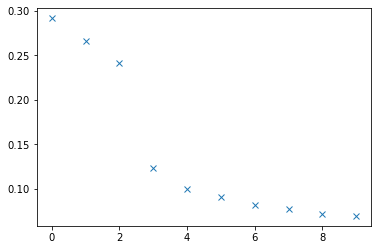

In [14]:
plt.plot(map[0],"x") # eigenvalues
plt.show()

[19, 20, 59, 26, 60, 27, 40, 41]
['00000000100001001', '00000000100001002', '00000000200001001', '00000000100002001', '00000000200001002', '00000000100002002', '00000000100012001', '00000000100012002']


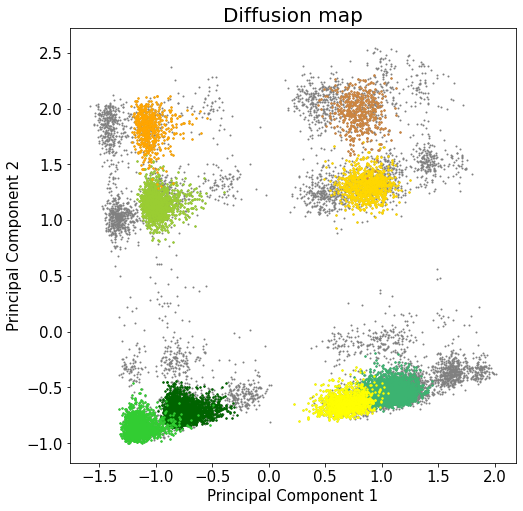

In [15]:
limit = 0.020
# Load partially data sorted 
hist1 = np.loadtxt("sketchmap/Cluster_conformer_aD4bD4_1.dat")
N, average = 1, hist1[:,3]   
for i in range(2,11): 
    histn = np.loadtxt("sketchmap/Cluster_conformer_aD4bD4_{}.dat".format(i))
    N, average = N + 1, average + histn[:,3]

# Calculate final block averages considering only probability values within a certain limit 
average = average / N
average = pd.DataFrame(average, columns=['Prob'])
average = average.drop(average[average['Prob'] < limit ].index, inplace=False)
average = average.sort_values(by='Prob',ascending=False)
indexlist = average.index.tolist()
print(indexlist)
hist = pd.read_csv("sketchmap/Cluster_conformer_aD4bD4_1.dat", names = ["Index", "Conformer", "Count_partial", "Prob", "Count_full"], sep = " ", dtype = str)
hist = hist.filter(indexlist, axis = 0)
targets = hist['Conformer'].tolist()
print(targets)

# project data on first two diffusion coordinates:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Diffusion map', fontsize = 20)

ax.scatter(map[1][0],map[1][1],c="gray",s=1)

colors = ['darkgreen', 'mediumseagreen', 'limegreen', 'yellowgreen', 'yellow', 'gold', 'orange','peru', "blue", "lightblue"]

for target, color in zip(targets,colors):
    indicesToKeep = conformers['Conformer'] == target
    ax.scatter(map[1][0][indicesToKeep]
               ,map[1][1][indicesToKeep]
               ,c = color
               ,s = 2)

ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)

# Pytabels

In [4]:
df = plumed.read_as_pandas("sketchmap/COLVAR_torsion_dimred_aD4bD4")
features = ['phi1_2', 'psi1_2', 'phi2_3', 'psi2_3', 'phi3_4', 'psi3_4', 'phi3_5', 'psi3_5', 'omega3_5', 'phi5_6', 'psi5_6', 'phi5_7', 'psi5_7', 'omega5_7', 'phi1_8', 'psi1_8', 'omega1_8']
for fn in features:
    df["sin_{}".format(fn)] = np.sin(df.loc[:,fn])
    df["cos_{}".format(fn)] = np.cos(df.loc[:,fn]) 
    df = df.drop(columns=["{}".format(fn)])
df = df.drop(columns = ["time"])
a = df.drop(df.index[20000:])
A = a.to_numpy()
#A = sparse.csr_matrix(A)
A = A.astype('float32')

conformers = conformer("sketchmap/COLVAR_torsion_dimred_aD4bD4")
conformers = conformers.drop(df.index[20000:])

<ipython-input-4-e7d2ed2c20d0>:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  df = plumed.read_as_pandas("sketchmap/COLVAR_torsion_dimred_aD4bD4")
<ipython-input-3-5af792f3281e>:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  df = plumed.read_as_pandas("{}".format(colvar))


In [119]:
l = A.shape[0]

In [120]:
f.close()

In [121]:
f = tb.open_file('dist.h5', 'w')
filters = tb.Filters(complevel=5, complib='blosc')
out = f.create_earray(f.root, 'colvar', tb.Float32Atom(), shape=(0, l), filters=filters, expectedrows= l)

In [105]:
@jit

def dist_tb(A):
    dist = np.zeros([1,l])
    for i in range(0,l):
        for j in range(0,l):
            dist[0,j] = np.sqrt(np.dot(A[i], A[i]) - 2 * np.dot(A[i], A[j]) + np.dot(A[j], A[j]))
        out.append(dist)
    f.close()
    return

In [122]:
start = time.time()
dist_tb(A)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 3676.5466430187225


In [5]:
file = tb.open_file('dist.h5', mode='r')
distance = file.root.colvar[:]

In [6]:
start = time.time()
map = dmap_pytables(A,distance,1.7,n=10)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 527.0193877220154


In [7]:
file.close()

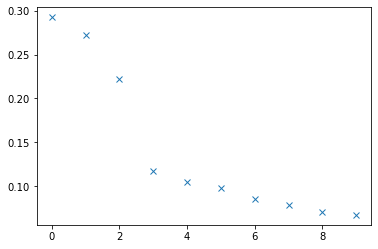

In [8]:
plt.plot(map[0],"x") # eigenvalues
plt.show()

[19, 20, 59, 26, 60, 27, 40, 41]
['00000000100001001', '00000000100001002', '00000000200001001', '00000000100002001', '00000000200001002', '00000000100002002', '00000000100012001', '00000000100012002']


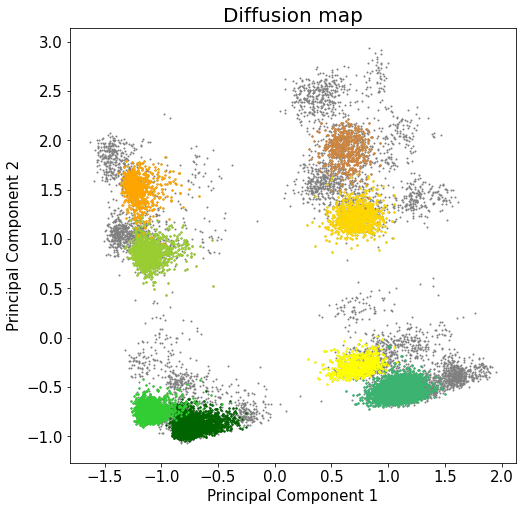

In [9]:
limit = 0.020
# Load partially data sorted 
hist1 = np.loadtxt("sketchmap/Cluster_conformer_aD4bD4_1.dat")
N, average = 1, hist1[:,3]   
for i in range(2,11): 
    histn = np.loadtxt("sketchmap/Cluster_conformer_aD4bD4_{}.dat".format(i))
    N, average = N + 1, average + histn[:,3]

# Calculate final block averages considering only probability values within a certain limit 
average = average / N
average = pd.DataFrame(average, columns=['Prob'])
average = average.drop(average[average['Prob'] < limit ].index, inplace=False)
average = average.sort_values(by='Prob',ascending=False)
indexlist = average.index.tolist()
print(indexlist)
hist = pd.read_csv("sketchmap/Cluster_conformer_aD4bD4_1.dat", names = ["Index", "Conformer", "Count_partial", "Prob", "Count_full"], sep = " ", dtype = str)
hist = hist.filter(indexlist, axis = 0)
targets = hist['Conformer'].tolist()
print(targets)

# project data on first two diffusion coordinates:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Diffusion map', fontsize = 20)

ax.scatter(map[1][0],map[1][1],c="gray",s=1)

colors = ['darkgreen', 'mediumseagreen', 'limegreen', 'yellowgreen', 'yellow', 'gold', 'orange','peru', "blue", "lightblue"]

for target, color in zip(targets,colors):
    indicesToKeep = conformers['Conformer'] == target
    ax.scatter(map[1][0][indicesToKeep]
               ,map[1][1][indicesToKeep]
               ,c = color
               ,s = 2)

ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)